## Notebook for data analysis of 'interneuron' sessions [mostly local photostimulation of random groups while imaging interneuron + excitatory responses]

In [1]:
%run /home/rlees/Documents/Code/Vape/jupyter/rob/rob_setup_notebook.ipynb

import utils.utils_funcs as uf
import utils.gsheets_importer as gsi
import utils.ia_funcs as ia 
from utils.paq2py import *

session_type = 'interneuron'


Suite2p path: ['/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/suite2p']
QNAP_path: /home/rlees/mnt/qnap 
QNAP_data_path /home/rlees/mnt/qnap/Data 
Pickle folder: /home/rlees/mnt/qnap/pkl_files 
Master pickle: /home/rlees/mnt/qnap/master_pkl/master_obj.pkl 
Figure save path: /home/rlees/mnt/qnap/Analysis/Figures 
STA movie save path: /home/rlees/mnt/qnap/Analysis/STA_movies 
S2 borders path: /home/rlees/mnt/qnap/Analysis/S2_borders


In [4]:
pkl_files = ia.listdirFullpath(pkl_folder + '/interneuron', '06_RL120.pkl')

session_ids = [pkl.split('/')[-1][:-4] for pkl in pkl_files]

for pkl, session_id in zip(pkl_files, session_ids):
    
    ses_obj = ia.loadPickle(pkl)

Loading pickle: /home/rlees/mnt/qnap/pkl_files/interneuron/2021-01-06_RL120.pkl


2021-01-06_RL120
number of interneurons: 42
searching for interneuron cell ids...
search completed.
Number of interneuron cells:  35


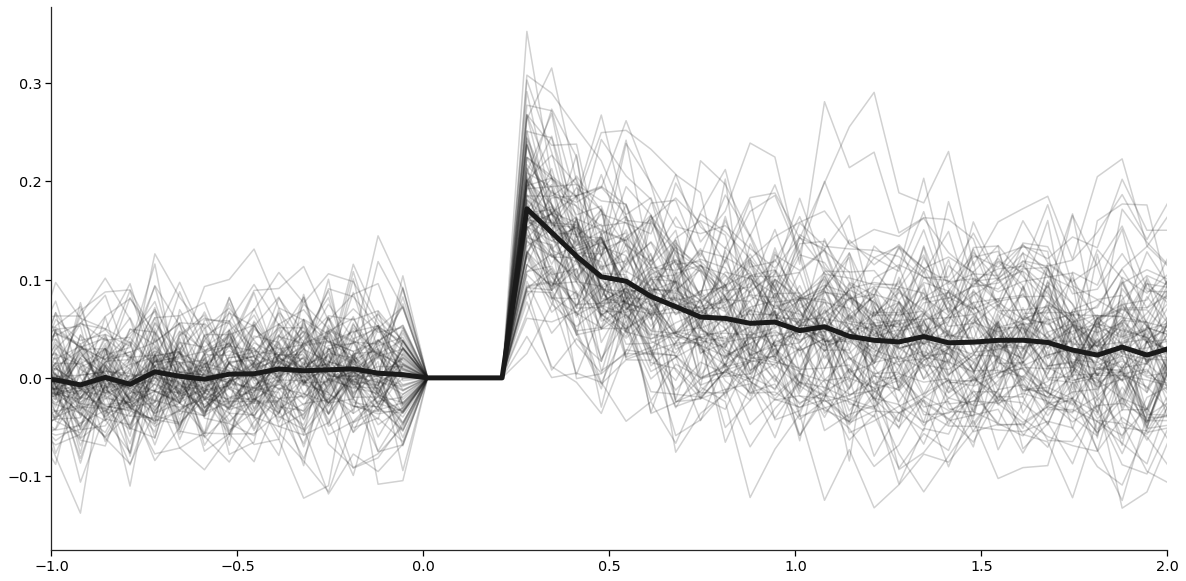

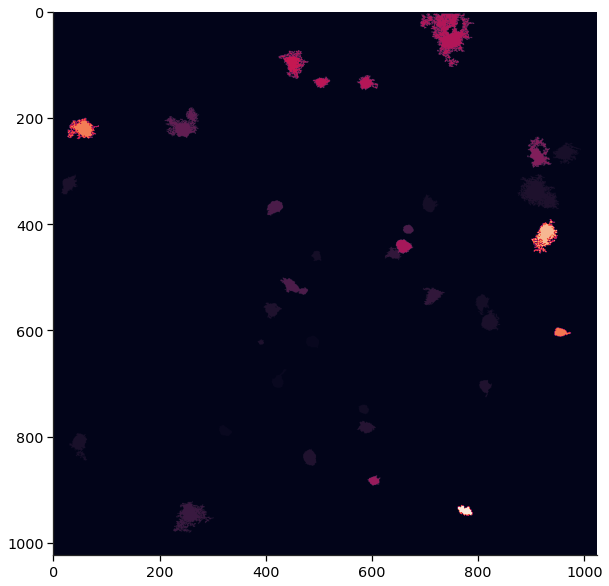

In [5]:
# manually pick out tdtomato cells in imagej
# load in points from imagej to python (maybe using target approach?)
# use points to assign new information to cells in the exp_objs, i.e. 'interneuron_id' = True/False
# plot activity of interneurons vs excitatory neurons on photostim and spont trials (all or subset?)
# add this metric to dataframe creation

exp_obj = ses_obj.photostim_r
print(exp_obj.sheet_name)

interneuron_points = ia.listdirFullpath(ses_obj.photostim_r.tiff_path, 'interneuron') 
interneuron_img = tf.imread(interneuron_points)

interneuron_coords = np.where(interneuron_img>0)
interneuron_img[interneuron_coords] = 1 # [y,x] coords

n_interneurons = len(interneuron_coords[0])

print('number of interneurons:', n_interneurons)

print('searching for interneuron cell ids...')

# make an image of every cell area, filled with the index of that cell
cell_img = np.zeros_like(interneuron_img, dtype='uint16')

cell_x = np.array(exp_obj.cell_x)
cell_y = np.array(exp_obj.cell_y)

for i, coord in enumerate(zip(cell_y[0], cell_x[0])):
    cell_img[coord] = i+1

# binary mask x cell image to get the cells that overlap with target areas
interneuron_cells = cell_img*interneuron_img

interneuron_cells = np.unique(interneuron_cells)[1:]-1 # correct the cell id due to zero indexing

exp_obj.interneurons = np.zeros([exp_obj.n_units[0]], dtype='bool')
exp_obj.interneurons[interneuron_cells] = True 

exp_obj.n_interneurons = np.sum(exp_obj.interneurons)

print('search completed.')
print('Number of interneuron cells: ', exp_obj.n_interneurons)

interneuron_trials = exp_obj.all_trials[0][exp_obj.interneurons]

plt.figure(figsize=(20,10))
plt.plot(exp_obj.time, np.mean(interneuron_trials, axis=(0)), 'k', alpha=0.2)
plt.plot(exp_obj.time, np.mean(interneuron_trials, axis=(0,2)), 'k', lw=5)
plt.xlim([-1,2])
plt.show()

interneuron_cell_ids = [exp_obj.cell_id[0][i] for i,b in enumerate(exp_obj.interneurons) if b]

plt.figure(figsize=(10,10))
plt.imshow(ia.s2pMasks(exp_obj.s2p_path, interneuron_cell_ids));

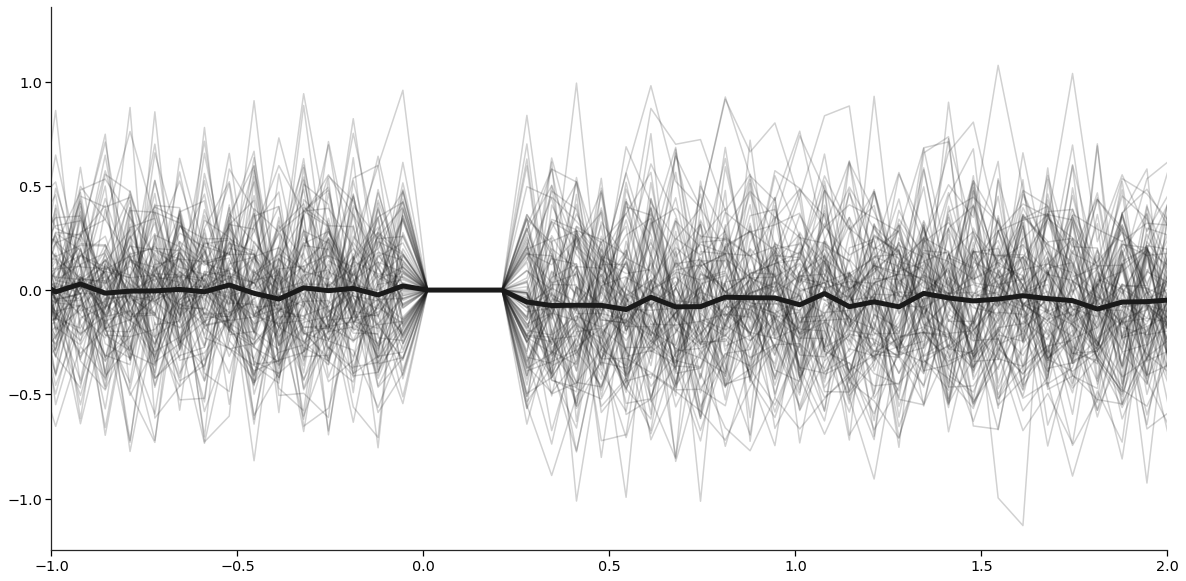

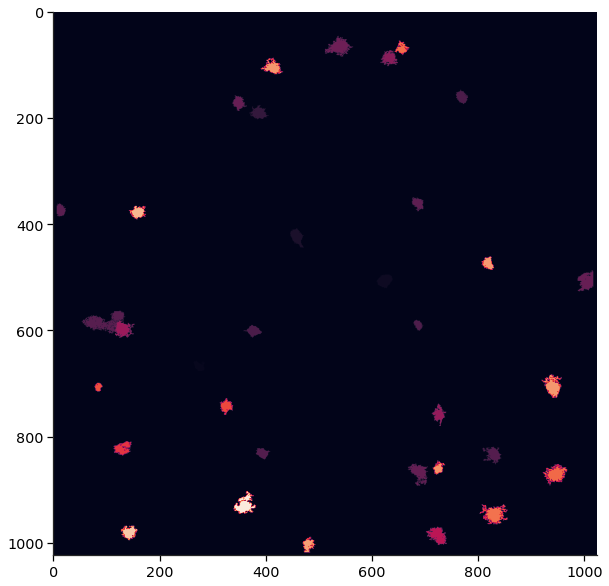

In [6]:
filter_exc = ~exp_obj.targeted_cells & ~exp_obj.interneurons

exc_neurons = np.where(filter_exc)[0]

exc_neurons = np.random.choice(exc_neurons, size=exp_obj.n_interneurons, replace=False)

exc_neuron_trials = exp_obj.all_trials[0][exc_neurons]

plt.figure(figsize=(20,10))
plt.plot(exp_obj.time, np.mean(exc_neuron_trials, axis=(0)), 'k', alpha=0.2)
plt.plot(exp_obj.time, np.mean(exc_neuron_trials, axis=(0,2)), 'k', lw=5)
plt.xlim([-1,2])
plt.show()

exc_neuron_cell_ids = np.array(exp_obj.cell_id[0])[exc_neurons]

plt.figure(figsize=(10,10))
plt.imshow(ia.s2pMasks(exp_obj.s2p_path, exc_neuron_cell_ids));

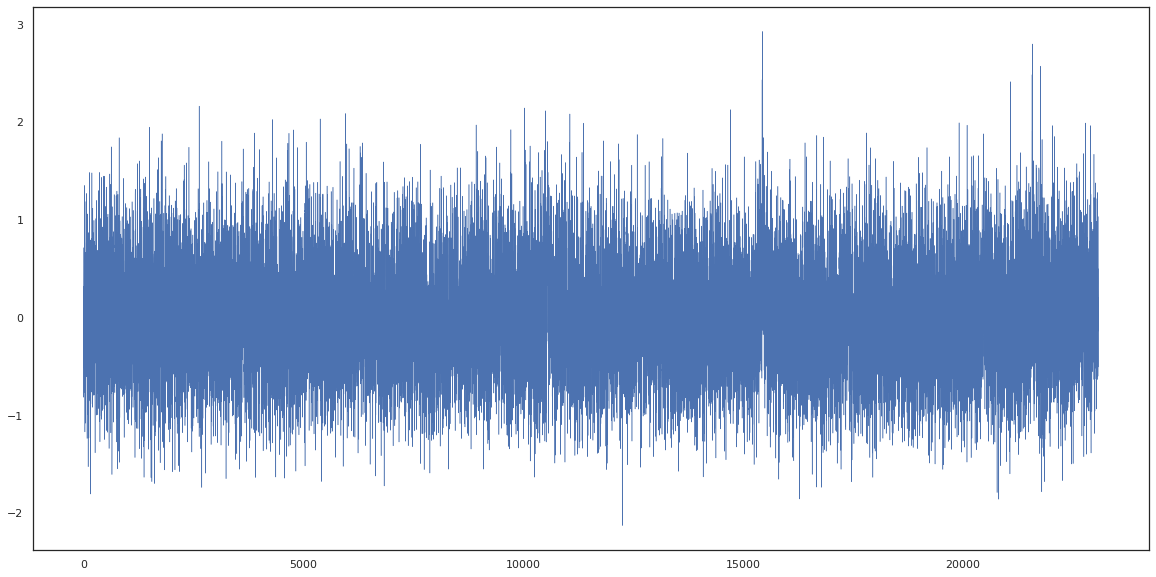

In [86]:
int_traces = exp_obj.dfof[0][exp_obj.interneurons][12]
plt.figure(figsize=(20,10))
plt.plot(int_traces.T, lw=0.5)
# plt.xlim([11000,12000]);
# plt.ylim([-1,5]);